<a href="https://colab.research.google.com/github/iris-kurapaty/CodingPractice/blob/main/Step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
pwd

'/content'

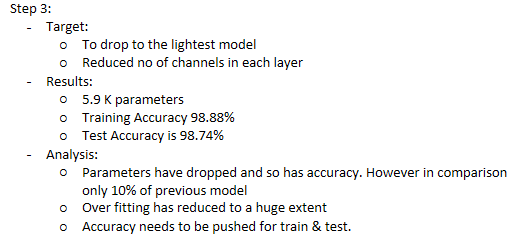

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from model import *
from utils import *

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 212587366.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 96831090.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68888869.60it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16799408.08it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


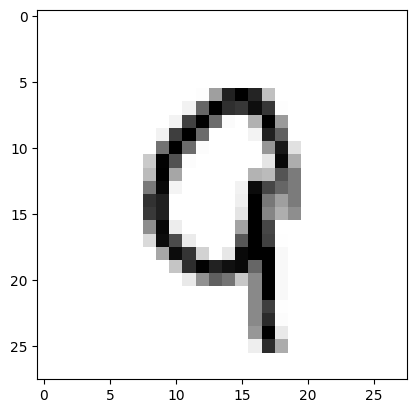

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_set = train_data.train_data
train_set = train_data.transform(train_set.numpy())

print('[Train]')
print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_data.train_data.size())
print(' - min:', torch.min(train_set))
print(' - max:', torch.max(train_set))
print(' - mean:', torch.mean(train_set))
print(' - std:', torch.std(train_set))
print(' - var:', torch.var(train_set))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


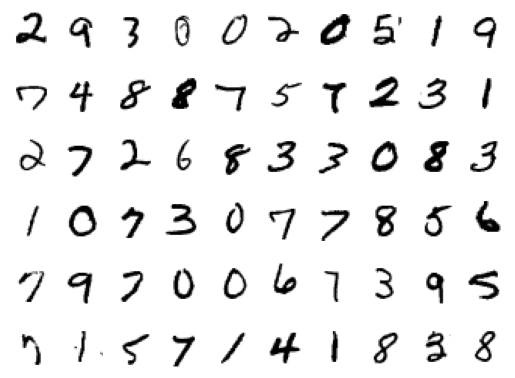

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [ ]:
from model import Net3


# Model Params

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_summary(Net3, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             576
              ReLU-4            [-1, 8, 24, 24]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6           [-1, 16, 12, 12]           1,152
              ReLU-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 10, 10]           1,152
              ReLU-9            [-1, 8, 10, 10]               0
        MaxPool2d-10              [-1, 8, 5, 5]               0
           Conv2d-11             [-1, 16, 5, 5]           1,152
             ReLU-12             [-1, 16, 5, 5]               0
           Conv2d-13              [-1, 8, 3, 3]           1,152
             ReLU-14              [-1, 

# Training and Testing


In [ ]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

# Let's Train and test our model

In [ ]:
model =  Net3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


Loss=0.15495891869068146 Batch_id=468 Accuracy=51.56: 100%|██████████| 469/469 [00:19<00:00, 24.25it/s]



Test set: Average loss: 0.2103, Accuracy: 9349/10000 (93.49%)

EPOCH: 1


Loss=0.08414625376462936 Batch_id=468 Accuracy=95.04: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]



Test set: Average loss: 0.1015, Accuracy: 9683/10000 (96.83%)

EPOCH: 2


Loss=0.0708426907658577 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]



Test set: Average loss: 0.1034, Accuracy: 9692/10000 (96.92%)

EPOCH: 3


Loss=0.06644587218761444 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]



Test set: Average loss: 0.0741, Accuracy: 9782/10000 (97.82%)

EPOCH: 4


Loss=0.1033245101571083 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]



Test set: Average loss: 0.0857, Accuracy: 9752/10000 (97.52%)

EPOCH: 5


Loss=0.12543877959251404 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]



Test set: Average loss: 0.0571, Accuracy: 9827/10000 (98.27%)

EPOCH: 6


Loss=0.027746660634875298 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]



Test set: Average loss: 0.0536, Accuracy: 9830/10000 (98.30%)

EPOCH: 7


Loss=0.020118510350584984 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]



Test set: Average loss: 0.0526, Accuracy: 9845/10000 (98.45%)

EPOCH: 8


Loss=0.07584833353757858 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]



Test set: Average loss: 0.0539, Accuracy: 9849/10000 (98.49%)

EPOCH: 9


Loss=0.016912255436182022 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]



Test set: Average loss: 0.0518, Accuracy: 9846/10000 (98.46%)

EPOCH: 10


Loss=0.08268668502569199 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:19<00:00, 23.75it/s]



Test set: Average loss: 0.0504, Accuracy: 9846/10000 (98.46%)

EPOCH: 11


Loss=0.008439497090876102 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]



Test set: Average loss: 0.0485, Accuracy: 9851/10000 (98.51%)

EPOCH: 12


Loss=0.009984327480196953 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]



Test set: Average loss: 0.0522, Accuracy: 9840/10000 (98.40%)

EPOCH: 13


Loss=0.06146770715713501 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.42it/s]



Test set: Average loss: 0.0463, Accuracy: 9874/10000 (98.74%)

EPOCH: 14


Loss=0.0067012193612754345 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]



Test set: Average loss: 0.0505, Accuracy: 9854/10000 (98.54%)



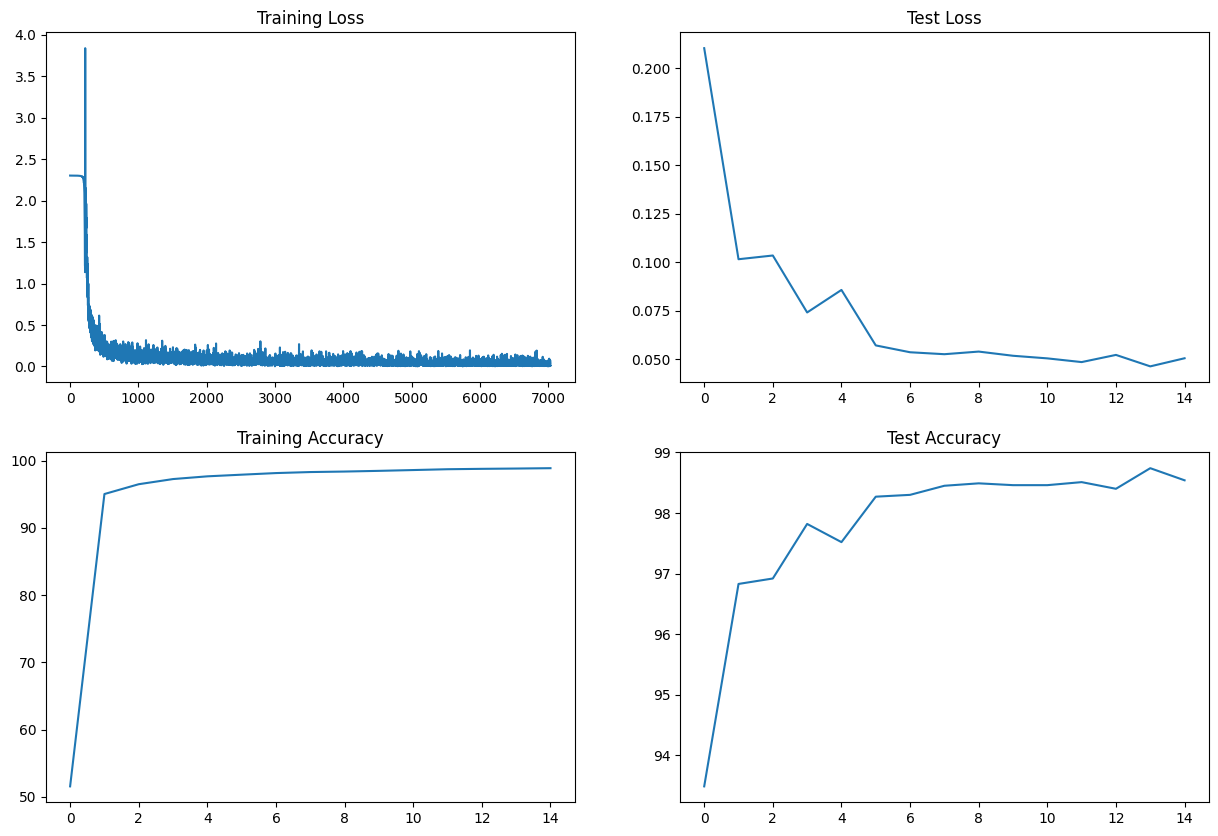

In [ ]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)